In [1]:
import numpy as np
import random
import pandas as pd

# Dataloader

In [2]:
class Dataloader:
    
    def __init__(self, data, labels, n_classes, batch_size=None, shuffle=False):

        assert len(data)==len(labels)
        self.__n_classes = n_classes
        self.__batch_size = batch_size
        self.__shuffle = shuffle
        self.__data = data
        self.__onehot_labels = self.__onehot(labels, self.__n_classes)
    
    def __onehot(self, labels, n_classes):
        onehot_vectors = []
        for _ in range(len(labels)):
            onehot_vectors.append([0] * n_classes)
        for i in range(len(labels)):
            onehot_vectors[i][labels[i][0]] = 1
        return onehot_vectors
    
    def __shuffle_dataset(self):
        c = list(zip(self.__data, self.__onehot_labels))
        random.shuffle(c)
        self.__data, self.__onehot_labels = zip(*c)

    def __iter__(self):
        
        if self.__shuffle:
            self.__shuffle_dataset()
            
        if self.__batch_size==None:
            yield (np.matrix(self.__data), np.matrix(self.__onehot_labels))
            return
            
        for idx in range(0, len(self.__data), self.__batch_size):
           # print(np.matrix(self.__data[idx:idx+self.__batch_size]).shape)
            yield (np.matrix(self.__data[idx:idx+self.__batch_size]), 
                   np.matrix(self.__onehot_labels[idx:idx+self.__batch_size]))

# Activation Functions

In [3]:
class Identical:
    
    def __init__(self): pass
    
    def __val(self, matrix):
        identical_value = np.matrix(matrix, dtype=float)
        return identical_value

    def derivative(self, matrix):
        temp = np.matrix(matrix, dtype=float)
        identical_derivative = np.matrix(np.full(np.shape(temp), 1.))
        return identical_derivative
    
    def __call__(self, matrix):
        return self.__val(matrix)
    

class Relu:
    
    def __init__(self): pass
    
    def __relu(self, matrix):
        relu_value = np.matrix(matrix, dtype=float)
        relu_value[matrix < 0] = 0
        return relu_value

    def derivative(self, matrix):
        relu_derivative = np.matrix(matrix, dtype=float)
        relu_derivative[matrix <= 0] = 0
        relu_derivative[matrix > 0] = 1
        return relu_derivative
    
    def __call__(self, matrix):
        return self.__relu(matrix)

    
class LeakyRelu:
    
    def __init__(self, negative_slope=0.01):
        self.negative_slope = 0.01
    
    def __val(self, matrix):
        leacky_relu_value = np.matrix(matrix, dtype=float)
        for i in range(matrix.shape[0]):
            for j in range(matrix.shape[1]):
                if matrix.item(i, j) < 0:
                    leacky_relu_value[i, j] = matrix.item(i, j) * self.negative_slope
        return leacky_relu_value

    def derivative(self, matrix):
        leacky_relu_derivative = np.matrix(matrix, dtype=float)
        leacky_relu_derivative[leacky_relu_derivative > 0] = 1
        leacky_relu_derivative[leacky_relu_derivative <= 0] = self.negative_slope
        return leacky_relu_derivative
    
    def __call__(self, matrix):
        return self.__val(matrix)

    
class Sigmoid:
    
    def __init__(self): pass

    def __val(self, matrix):
        sigmoid_value = np.matrix(matrix, dtype=float)
        for i in range(len(matrix)):
            sigmoid_value[i] = 1 / (1 + np.exp(-matrix[i]))
        return sigmoid_value

    def derivative(self, matrix):
        sigmoid_derivative = np.matrix(matrix, dtype=float)
        for i in range(len(matrix)):
            gz = 1 / (1 + np.exp(-matrix[i]))
            for j in range(gz.shape[1]):
                sigmoid_derivative[i, j] = gz[0, j] * (1 - gz[0, j])
        return sigmoid_derivative
    
    def __call__(self, matrix):
        return self.__val(matrix)


class Softmax:
    
    def __init__(self): pass

    def __val(self, matrix):
        _max = matrix[0, 0]
        for i in range(matrix.shape[0]):
            for j in range(matrix.shape[1]):
                if _max < matrix[i, j]:
                    _max = matrix[i, j]
         
        softmax_value = np.matrix(matrix, dtype=float)
        
        for i in range(softmax_value.shape[0]):
            for j in range(softmax_value.shape[1]):
                softmax_value[i, j] = softmax_value[i, j] - _max

        for i in range(matrix.shape[0]):
            _sum = 0
            for j in range(matrix.shape[1]):
                _sum += np.exp(matrix[i, j])
            for j in range(matrix.shape[1]):
                softmax_value[i, j] = np.exp(matrix[i, j]) / _sum
        return softmax_value

    def derivative(self, matrix):
        softmax_derivative = np.matrix(matrix, dtype=float)
        d = self.__val(softmax_derivative)
        for i in range(softmax_derivative.shape[0]):
            for j in range(softmax_derivative.shape[1]):
                softmax_derivative[i, j] = d[i, j] * (1 - d[i, j])
        return softmax_derivative
    
    def __call__(self, matrix):
        return self.__val(matrix)

# Loss Function

In [4]:
from scipy.special import softmax

class CrossEntropy: #(with softmax)
    
    def __init__(self): pass

    def __val(self, true_val, expected_val):
        assert np.shape(true_val)==np.shape(expected_val)
        true_val_softmax = Softmax()(true_val)
        cross_entropy_value = np.multiply(expected_val, np.ma.log(true_val_softmax)) * (-1)
        cross_entropy_value = np.sum(cross_entropy_value, axis = 1)
#         expected_val_softmax = Softmax()(expected_val)
#         cross_entropy_value = np.matrix(matrix, dtype=float)
#         for i in range(cross_entropy_value.shape[0]):
#             for j in range(cross_entropy_value.shape[1]):
#                 cross_entropy_value[i, j] = -1 * expected_val[i, j] * np.log(true_val[i, j])
        return cross_entropy_value
        
    def derivative(self, true_val, expected_val):
        assert np.shape(true_val)==np.shape(expected_val)
        true_val_softmax = Softmax()(true_val)
        cross_entropy_derivative = true_val_softmax - expected_val
        return cross_entropy_derivative
    
    def __call__(self, true_val, expected_val):
        return self.__val(true_val, expected_val)


# Layer

In [55]:
class Layer:

    DEFAULT_LOW, DEFAULT_HIGH, DEFAULT_MEAN, DEFAULT_VAR = 0, 0.05, 0., 1.
  
    def __init__(self, input_size, output_size, 
                 activation=Identical(), initial_weight='uniform', **initializing_parameters):
        
        assert type(initial_weight)==str, 'Undefined activation function!'
        self.__weight_initializer_dict = {'uniform':self.__uniform_weight, 'normal':self.__normal_weight}
        assert initial_weight in self.__weight_initializer_dict, 'Undefined weight initialization function!'
        
        
        self.__n_neurons = output_size
        weight_initializer = self.__weight_initializer_dict[initial_weight]
        self.__weight = weight_initializer(input_size, self.__n_neurons, **initializing_parameters)
        self.__bias = weight_initializer(1, self.__n_neurons, **initializing_parameters)
        self.__activation = activation

        self.__last_input = None
        self.__last_activation_input = None
        self.__last_activation_output = None
        self.__last_activation_derivative = None
        
    
    def forward(self, layer_input):
        assert np.ndim(layer_input)==2
        assert np.size(self.__weight,0) == np.size(layer_input,1)
        self.__last_input = layer_input
        # is multiply ok?
        self.__last_activation_input = np.matmul(self.__last_input, self.__weight) + self.__bias
        
                
        self.__last_activation_output = self.__activation(self.__last_activation_input)
        self.__last_activation_derivative = self.__activation.derivative(self.__last_activation_input)
        return self.__last_activation_output
    
    def update_weights(self, backprop_tensor, lr):
        assert np.ndim(backprop_tensor)==2
        assert np.size(backprop_tensor,0) == np.size(self.__last_activation_derivative,0)
        assert np.size(backprop_tensor,1) == self.__n_neurons
        
        rondlbrondy = np.multiply(backprop_tensor, self.__last_activation_derivative)
        ret = np.matmul(rondlbrondy, np.transpose(self.__weight))
        delta = np.matmul(np.transpose(self.__last_input), rondlbrondy)
    #    delta = np.matmul(rondYbrondi_1, np.transpose(self.__last_input))
        self.__weight = self.__weight - (lr * delta)
    #    self.__bias = (1 + lr * delta) * self.__bias
        mt = np.matrix(np.zeros(rondlbrondy.shape[0])) + 1
        rondlbrondb = np.matmul(mt, rondlbrondy)
        self.__bias = self.__bias - lr * rondlbrondb
        return ret

    def __uniform_weight(self, dim1, dim2, **initializing_parameters):
        low, high = self.DEFAULT_LOW, self.DEFAULT_HIGH
        if 'low' in initializing_parameters.keys(): low = initializing_parameters['low']
        if 'high' in initializing_parameters.keys(): high = initializing_parameters['high']
        weight = np.random.uniform(low, high, (dim1, dim2))
        return weight

    def __normal_weight(self, dim1, dim2, **initializing_parameters):
        mean, var = self.DEFAULT_MEAN, self.DEFAULT_VAR
        if 'mean' in initializing_parameters.keys(): mean = initializing_parameters['mean']
        if 'var' in initializing_parameters.keys(): var = initializing_parameters['var']
        weight = np.random.normal(mean, np.sqrt(var), (dim1, dim2))
        return weight
    
    def get_act_output(self):
        return self.__last_activation_output
    
    @property
    def n_neurons(self): return self.__n_neurons
    
    @property
    def weight(self): return self.__weight
    
    @property
    def bias(self): return self.__bias
    
    @property
    def activation(self): return self.__activation


# Feed Forward Neural Network

In [73]:
class FeedForwardNN:
    
    def __init__(self, input_shape):
        
        self.__input_shape = input_shape
        self.__output_shape = None
        
        self.__layers_list = []
        
        self.__lr = None
        self.__loss = None
        
        self.train = []
        self.train_y = []
        self.test = []
        self.test_y = []
        
    def add_layer(self, n_neurons, activation=Relu(), initial_weight='uniform', **initializing_parameters):
         
        assert type(n_neurons)==int, "Invalid number of neurons for the layer!"
        assert n_neurons>0, "Invalid number of neurons for the layer!"
        
        n_prev_neurons = self.__input_shape if len(self.__layers_list)==0 else self.__layers_list[-1].n_neurons
        new_layer = Layer(n_prev_neurons, n_neurons, activation, initial_weight, **initializing_parameters)
        self.__layers_list.append(new_layer)
        self.__output_shape = self.__layers_list[-1].n_neurons 
      
    
    def set_training_param(self, loss=CrossEntropy(), lr=1e-3):
        assert self.__layers_list, "Uncomplete model!"
        self.__loss = loss
        self.__lr = lr
    
    
    def forward(self, network_input):
        assert type(self.__output_shape) != None, "Model is not compiled!"

        network_output = self.__layers_list[0].forward(network_input)
        for i in range(1, len(self.__layers_list)):
            network_output = self.__layers_list[i].forward(network_output)

        return network_output
    
    
    def fit(self, epochs, trainloader, testloader=None, print_results=True):
        
        assert type(self.__output_shape) != None, "Model is not compiled!"
        assert type(self.__lr) != None and type(self.__loss) != None, "Training paramenters are not set!"

        log = {"train_accuracy":[], "train_loss":[], "test_accuracy":[], "test_loss":[]}
        
        for epoch in range(1, epochs+1):
            
            if print_results: 
                print('Epoch {}:'.format(epoch)) 
             
            self.train = []
            self.train_y = []
            self.test = []
            self.test_y = []
            
            average_accuracy, average_loss = self.__train(trainloader)
            log['train_accuracy'].append(average_accuracy)
            log['train_loss'].append(average_accuracy)
            if print_results:
                print('\tTrain: Average Accuracy: {}\tAverage Loss: {}'.format(average_accuracy, average_loss))
            
            if type(testloader) != type(None):
                average_accuracy, average_loss = self.__test(testloader)
                log['test_accuracy'].append(average_accuracy)
                log['test_loss'].append(average_loss)
                if print_results:
                    print('\tTest: Average Accuracy: {}\tAverage Loss: {}'.format(average_accuracy, average_loss))
                    
        return log
    
    
    def __train(self, trainloader):
        bach_accuracies, batch_losses = [], []
        for x_train, y_train in trainloader:
            batch_accuracy, batch_loss = self.__train_on_batch(x_train, y_train)
            bach_accuracies.append(batch_accuracy)
            batch_losses.append(batch_loss)
        return np.mean(bach_accuracies), np.mean(batch_losses)
    
    
    def __test(self, testloader):
        bach_accuracies, batch_losses = [], []
        for x_test, y_test in testloader:
            batch_accuracy, batch_loss = self.__test_on_batch(x_test, y_test)
            bach_accuracies.append(batch_accuracy)
            batch_losses.append(batch_loss)
        return np.mean(bach_accuracies), np.mean(batch_losses)

    
    def __train_on_batch(self, x_batch, y_batch):
        out = self.forward(x_batch)
        batch_average_loss = np.mean(self.__loss(out, y_batch))
        batch_accuracy = self.__compute_accuracy(out, y_batch)
        self.__update_weights(out, y_batch)
        
        self.train.append(self.__layers_list[-2].get_act_output())
        self.train_y.append(y_batch)
        return (batch_accuracy, batch_average_loss)
        
        
    def __test_on_batch(self, x_batch, y_batch):
        out = self.forward(x_batch)
        batch_average_loss = np.mean(self.__loss(out, y_batch))
        batch_accuracy = self.__compute_accuracy(out, y_batch)
        
        self.test.append((self.__layers_list[-2].get_act_output()))
        self.test_y.append(y_batch)
        return (batch_accuracy, batch_average_loss)
        
    def __get_labels(self, outputs):
        labels = []
        for out in outputs:
            labels.append(out.argmax(axis = 1))
        return labels
    
    
    def __compute_accuracy(self, output, expected_output):
#         length = output.shape[0]
#         counter = 0
#         for idx in range(length - 1):
#         i = output.argmax(axis = 1)
#         j = expected_output.argmax(axis = 1)
#         for x in range(i.shape[0]):
#             if i[x, 0] == j[x, 0]:
#                 counter += 1
        counter = (output.argmax(axis = 1) == expected_output.argmax(axis = 1)).sum()
        accuracy = counter / len(output)
        return accuracy
    
    
    
    def __update_weights(self, output, y_train):
        length = len(self.__layers_list)
        ret = self.__loss.derivative(output, y_train)
        for i in range(length - 1, -1, -1):
            ret = self.__layers_list[i].update_weights(ret, self.__lr)
        return

# Load

In [7]:
import csv
def read_from_file(path):
    file_content = pd.read_csv(path)
    return file_content.values.tolist()

train_data = read_from_file("dataset/trainData.csv")
train_labels = read_from_file("dataset/trainLabels.csv")
test_data = read_from_file("dataset/testData.csv")
test_labels = read_from_file("dataset/testLabels.csv")

In [8]:
for i in range(len(train_data)):
    for j in range(len(train_data[i])):
        train_data[i][j] = int(train_data[i][j]) / 255
for i in range(len(test_data)):
    for j in range(len(test_data[i])):
        test_data[i][j] = int(test_data[i][j]) / 255

<div dir = "rtl">
توابع فعال ساز بعضا به صورت نمایی هستند و اگر داده ها نرمالیزه نشوند ممکن است شاهد سرریز باشیم. در نتیجه از دقت اعداد کاسته میشود. به همین جهت فرایند یادگیری شبکه عصبی ممکن است با اختلال مواجه شود. این مورد در مرحله gradient descent 
بسیار تاثیرگذار است.
    <br>
    همچنین وقتی داده ها نرمالیزه میشوند اختلافها کم میشود و داده های پرت تاثیر چندانی روی مدل نخواهند داشت.
</div>

In [9]:
temp = []
for i in range(int(len(train_labels) / 100)):
    if train_labels[i] not in temp:
        temp.append(train_labels[i])
        print("Class", train_labels[i], "example:")
        print(train_data[i])

Class [0] example:
[0.0, 0.0, 0.0, 0.0, 0.0, 0.00392156862745098, 0.0, 0.0, 0.0, 0.0, 0.1607843137254902, 0.7372549019607844, 0.403921568627451, 0.21176470588235294, 0.18823529411764706, 0.16862745098039217, 0.3411764705882353, 0.6588235294117647, 0.5215686274509804, 0.06274509803921569, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.00392156862745098, 0.0, 0.0, 0.0, 0.19215686274509805, 0.5333333333333333, 0.8588235294117647, 0.8470588235294118, 0.8941176470588236, 0.9254901960784314, 1.0, 1.0, 1.0, 1.0, 0.8509803921568627, 0.8431372549019608, 0.996078431372549, 0.9058823529411765, 0.6274509803921569, 0.17647058823529413, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.054901960784313725, 0.6901960784313725, 0.8705882352941177, 0.8784313725490196, 0.8313725490196079, 0.796078431372549, 0.7764705882352941, 0.7686274509803922, 0.7843137254901961, 0.8431372549019608, 0.8, 0.792156862745098, 0.788235294117647, 0.788235294117647, 0.788235294117647, 0.8196078431372549, 0.85490

In [ ]:
# import matplotlib.pyplot as plt

# fig = plt.figure()
# X = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
# plt.figure(figsize=(9, 10))
# plt.xticks(list(range(len(X))), X)
# plt.hist(train_labels, width=0.75, align='right')
# plt.hist(test_labels, width=0.75, align='right') 
# plt.show()

<div dir = "rtl">
قطعا کد بالا جهت مشاهده نمودار داده های آموزش و تست قرار داده شده است اما با توجه به کمبود مموری قابل اجرا در ژوپیتر نیست. فلذا عکس آن در کنار فایلها قرار داده شده است. 
<br>
    همانطور که مشاهده میشود از هر کلاس داده آموزش ۶۰۰۰ تا داریم که در مجموع ۶۰۰۰۰ میشود و از هر کلاس داده تست ۱۰۰۰ تا داریم که در مجموع ۱۰۰۰۰ تا میشود
</div>

# Training Sample Code

In [10]:

INPUT_SHAPE = 784
LEARNING_RATE = 0.001
EPOCHS = 20
TRAINLOADER = Dataloader(train_data, train_labels, 10, 32)
TESTLOADER = Dataloader(test_data, test_labels, 10, 32)

network = FeedForwardNN(INPUT_SHAPE)
network.add_layer(20, input_shape=INPUT_SHAPE, activation=LeakyRelu(), weight_initializer='uniform')
network.add_layer(15, activation=Relu(), weight_initializer='normal')
network.add_layer(10, activation=Identical(), weight_initializer='uniform')
network.set_training_param(loss=CrossEntropy(), lr=LEARNING_RATE)

log = network.fit(EPOCHS, TRAINLOADER, TESTLOADER)

Epoch 1:
	Train: Average Accuracy: 0.4648795698924731	Average Loss: 1.384009391162046
	Test: Average Accuracy: 0.6794728434504793	Average Loss: 0.8430000708601827
Epoch 2:
	Train: Average Accuracy: 0.7479139784946237	Average Loss: 0.6979325729983545
	Test: Average Accuracy: 0.776930244941427	Average Loss: 0.645923141101621
Epoch 3:
	Train: Average Accuracy: 0.8001295698924731	Average Loss: 0.5686318848616352
	Test: Average Accuracy: 0.802589190628328	Average Loss: 0.5708502512546203
Epoch 4:
	Train: Average Accuracy: 0.8178478494623657	Average Loss: 0.5180288876215405
	Test: Average Accuracy: 0.8202609158679447	Average Loss: 0.5167363002046599
Epoch 5:
	Train: Average Accuracy: 0.8335311827956989	Average Loss: 0.47580360224379104
	Test: Average Accuracy: 0.8310436634717785	Average Loss: 0.48695227703351024
Epoch 6:
	Train: Average Accuracy: 0.843131182795699	Average Loss: 0.4451101111204133
	Test: Average Accuracy: 0.8411408413205538	Average Loss: 0.45881204291052474
Epoch 7:
	Train: A

# PART 3

In [11]:
INPUT_SHAPE = 784
LEARNING_RATE = 0.001
EPOCHS = 30
TRAINLOADER = Dataloader(train_data, train_labels, 10, 32)
TESTLOADER = Dataloader(test_data, test_labels, 10, 32)

network = FeedForwardNN(INPUT_SHAPE)
network.add_layer(20, input_shape=INPUT_SHAPE, activation=Relu(), weight_initializer='uniform')
network.add_layer(15, activation=Relu(), weight_initializer='normal')
network.add_layer(10, activation=Relu(), weight_initializer='uniform')
network.set_training_param(loss=CrossEntropy(), lr=LEARNING_RATE)

log = network.fit(EPOCHS, TRAINLOADER, TESTLOADER)

Epoch 1:
	Train: Average Accuracy: 0.46706182795698925	Average Loss: 1.3615326808539312
	Test: Average Accuracy: 0.6750798722044729	Average Loss: 0.8775650037553455
Epoch 2:
	Train: Average Accuracy: 0.726163440860215	Average Loss: 0.745089861954689
	Test: Average Accuracy: 0.771339190628328	Average Loss: 0.6672902979192512
Epoch 3:
	Train: Average Accuracy: 0.7828795698924731	Average Loss: 0.6118421779291596
	Test: Average Accuracy: 0.7950146432374867	Average Loss: 0.5962306588395018
Epoch 4:
	Train: Average Accuracy: 0.8061462365591398	Average Loss: 0.5469179922482026
	Test: Average Accuracy: 0.8112886048988286	Average Loss: 0.536234462712526
Epoch 5:
	Train: Average Accuracy: 0.8251967741935483	Average Loss: 0.49139947383233196
	Test: Average Accuracy: 0.824966719914803	Average Loss: 0.49739889269090853
Epoch 6:
	Train: Average Accuracy: 0.8384317204301076	Average Loss: 0.45478259515460984
	Test: Average Accuracy: 0.8328541001064963	Average Loss: 0.4752351890512218
Epoch 7:
	Train: 

In [13]:
print(log)

{'train_accuracy': [0.46706182795698925, 0.726163440860215, 0.7828795698924731, 0.8061462365591398, 0.8251967741935483, 0.8384317204301076, 0.8458317204301076, 0.8528650537634409, 0.8580317204301076, 0.8625983870967743, 0.8667483870967743, 0.8700983870967742, 0.8722317204301075, 0.8749983870967742, 0.8767155913978495, 0.8789483870967743, 0.8803317204301075, 0.8820150537634409, 0.8834817204301075, 0.8849817204301076, 0.8862983870967742, 0.8877817204301076, 0.8885983870967742, 0.8893317204301076, 0.889765053763441, 0.8909317204301076, 0.891181182795699, 0.8920145161290324, 0.8931145161290324, 0.8939645161290323], 'train_loss': [0.46706182795698925, 0.726163440860215, 0.7828795698924731, 0.8061462365591398, 0.8251967741935483, 0.8384317204301076, 0.8458317204301076, 0.8528650537634409, 0.8580317204301076, 0.8625983870967743, 0.8667483870967743, 0.8700983870967742, 0.8722317204301075, 0.8749983870967742, 0.8767155913978495, 0.8789483870967743, 0.8803317204301075, 0.8820150537634409, 0.8834

In [14]:
INPUT_SHAPE = 784
LEARNING_RATE = 0.01
EPOCHS = 30
TRAINLOADER = Dataloader(train_data, train_labels, 10, 32)
TESTLOADER = Dataloader(test_data, test_labels, 10, 32)

network = FeedForwardNN(INPUT_SHAPE)
network.add_layer(20, input_shape=INPUT_SHAPE, activation=Relu(), weight_initializer='uniform')
network.add_layer(15, activation=Relu(), weight_initializer='normal')
network.add_layer(10, activation=Relu(), weight_initializer='uniform')
network.set_training_param(loss=CrossEntropy(), lr=LEARNING_RATE)

log = network.fit(EPOCHS, TRAINLOADER, TESTLOADER)

Epoch 1:
	Train: Average Accuracy: 0.10103494623655913	Average Loss: 2.3035424372737063
	Test: Average Accuracy: 0.09984025559105432	Average Loss: 2.302585092994046
Epoch 2:
	Train: Average Accuracy: 0.1000016129032258	Average Loss: 2.302585092994046
	Test: Average Accuracy: 0.09984025559105432	Average Loss: 2.302585092994046
Epoch 3:
	Train: Average Accuracy: 0.1000016129032258	Average Loss: 2.302585092994046
	Test: Average Accuracy: 0.09984025559105432	Average Loss: 2.302585092994046
Epoch 4:
	Train: Average Accuracy: 0.1000016129032258	Average Loss: 2.302585092994046
	Test: Average Accuracy: 0.09984025559105432	Average Loss: 2.302585092994046
Epoch 5:
	Train: Average Accuracy: 0.1000016129032258	Average Loss: 2.302585092994046
	Test: Average Accuracy: 0.09984025559105432	Average Loss: 2.302585092994046
Epoch 6:
	Train: Average Accuracy: 0.1000016129032258	Average Loss: 2.302585092994046
	Test: Average Accuracy: 0.09984025559105432	Average Loss: 2.302585092994046
Epoch 7:
	Train: Ave

In [15]:
print(log)

{'train_accuracy': [0.10103494623655913, 0.1000016129032258, 0.1000016129032258, 0.1000016129032258, 0.1000016129032258, 0.1000016129032258, 0.1000016129032258, 0.1000016129032258, 0.1000016129032258, 0.1000016129032258, 0.1000016129032258, 0.1000016129032258, 0.1000016129032258, 0.1000016129032258, 0.1000016129032258, 0.1000016129032258, 0.1000016129032258, 0.1000016129032258, 0.1000016129032258, 0.1000016129032258, 0.1000016129032258, 0.1000016129032258, 0.1000016129032258, 0.1000016129032258, 0.1000016129032258, 0.1000016129032258, 0.1000016129032258, 0.1000016129032258, 0.1000016129032258, 0.1000016129032258], 'train_loss': [0.10103494623655913, 0.1000016129032258, 0.1000016129032258, 0.1000016129032258, 0.1000016129032258, 0.1000016129032258, 0.1000016129032258, 0.1000016129032258, 0.1000016129032258, 0.1000016129032258, 0.1000016129032258, 0.1000016129032258, 0.1000016129032258, 0.1000016129032258, 0.1000016129032258, 0.1000016129032258, 0.1000016129032258, 0.1000016129032258, 0.

In [16]:
INPUT_SHAPE = 784
LEARNING_RATE = 0.0001
EPOCHS = 30
TRAINLOADER = Dataloader(train_data, train_labels, 10, 32)
TESTLOADER = Dataloader(test_data, test_labels, 10, 32)

network = FeedForwardNN(INPUT_SHAPE)
network.add_layer(20, input_shape=INPUT_SHAPE, activation=Relu(), weight_initializer='uniform')
network.add_layer(15, activation=Relu(), weight_initializer='normal')
network.add_layer(10, activation=Relu(), weight_initializer='uniform')
network.set_training_param(loss=CrossEntropy(), lr=LEARNING_RATE)

log = network.fit(EPOCHS, TRAINLOADER, TESTLOADER)

Epoch 1:
	Train: Average Accuracy: 0.10331827956989247	Average Loss: 2.250324381935506
	Test: Average Accuracy: 0.11193423855165067	Average Loss: 2.2301757781511404
Epoch 2:
	Train: Average Accuracy: 0.13853602150537633	Average Loss: 2.2093929713606513
	Test: Average Accuracy: 0.1545926517571885	Average Loss: 2.185446641054678
Epoch 3:
	Train: Average Accuracy: 0.2674059139784946	Average Loss: 2.0294177902729635
	Test: Average Accuracy: 0.4237020766773163	Average Loss: 1.5721943269018526
Epoch 4:
	Train: Average Accuracy: 0.48780752688172047	Average Loss: 1.2906490503156978
	Test: Average Accuracy: 0.5381456336528222	Average Loss: 1.1561675553764152
Epoch 5:
	Train: Average Accuracy: 0.5527913978494624	Average Loss: 1.1126461395350276
	Test: Average Accuracy: 0.575412673056443	Average Loss: 1.0753811493618917
Epoch 6:
	Train: Average Accuracy: 0.5776424731182795	Average Loss: 1.04893024688073
	Test: Average Accuracy: 0.5965788072417465	Average Loss: 1.0173755852442832
Epoch 7:
	Train: 

In [17]:
print(log)

{'train_accuracy': [0.10331827956989247, 0.13853602150537633, 0.2674059139784946, 0.48780752688172047, 0.5527913978494624, 0.5776424731182795, 0.6001930107526882, 0.6409263440860214, 0.6796440860215053, 0.6975790322580645, 0.7108301075268817, 0.7241967741935483, 0.7357129032258064, 0.7505962365591398, 0.7659118279569893, 0.7754956989247311, 0.7816623655913979, 0.7867623655913979, 0.7919790322580645, 0.7969962365591398, 0.8009629032258064, 0.8039629032258064, 0.8062129032258064, 0.8092462365591397, 0.8118962365591398, 0.8136795698924731, 0.8157795698924731, 0.8181629032258064, 0.8204129032258064, 0.8224795698924731], 'train_loss': [0.10331827956989247, 0.13853602150537633, 0.2674059139784946, 0.48780752688172047, 0.5527913978494624, 0.5776424731182795, 0.6001930107526882, 0.6409263440860214, 0.6796440860215053, 0.6975790322580645, 0.7108301075268817, 0.7241967741935483, 0.7357129032258064, 0.7505962365591398, 0.7659118279569893, 0.7754956989247311, 0.7816623655913979, 0.7867623655913979

<div dir = "rtl">
همانطور که مشاهده میشود مقدار ۰.۰۰۱ که مقدار بهینه بود در انتها دقت ۸۶ درصد به ما میدهد. در صورتی که با ده برابر کردن آن دقت به شدت کاهش می یابد و نتیجه میگیریم مقادیر بزرگ برای نرخ یادگیری مناسب نیستند. همچنین با یک دهم کردن آن دقت کاهش میابد اما نه مانند حالت قبل که نتیجه قسمت قبل را تقویت میکند. در کل نرخ یادگیری نباید خیلی بزرگ باشد.
</div>

In [27]:
INPUT_SHAPE = 784
LEARNING_RATE = 0.001
EPOCHS = 30
TRAINLOADER = Dataloader(train_data, train_labels, 10, 32)
TESTLOADER = Dataloader(test_data, test_labels, 10, 32)

network = FeedForwardNN(INPUT_SHAPE)
network.add_layer(20, input_shape=INPUT_SHAPE, activation=LeakyRelu(), weight_initializer='uniform')
network.add_layer(15, activation=LeakyRelu(), weight_initializer='normal')
network.add_layer(10, activation=LeakyRelu(), weight_initializer='uniform')
network.set_training_param(loss=CrossEntropy(), lr=LEARNING_RATE)

log = network.fit(EPOCHS, TRAINLOADER, TESTLOADER)

Epoch 1:
	Train: Average Accuracy: 0.47421290322580645	Average Loss: 1.363899243505354
	Test: Average Accuracy: 0.7040202342917998	Average Loss: 0.8213303368433652
Epoch 2:
	Train: Average Accuracy: 0.7299301075268817	Average Loss: 0.7444270627864371
	Test: Average Accuracy: 0.7645500532481363	Average Loss: 0.687237514059863
Epoch 3:
	Train: Average Accuracy: 0.7844795698924731	Average Loss: 0.60362126579223
	Test: Average Accuracy: 0.7919062832800852	Average Loss: 0.6017312526951943
Epoch 4:
	Train: Average Accuracy: 0.8046801075268817	Average Loss: 0.5481097936845107
	Test: Average Accuracy: 0.8119741746538871	Average Loss: 0.5376180621607725
Epoch 5:
	Train: Average Accuracy: 0.824063440860215	Average Loss: 0.4968378820984349
	Test: Average Accuracy: 0.8218716719914803	Average Loss: 0.5076726032591297
Epoch 6:
	Train: Average Accuracy: 0.8373967741935484	Average Loss: 0.4573795028876081
	Test: Average Accuracy: 0.8288471778487753	Average Loss: 0.4811428321990362
Epoch 7:
	Train: Ave

In [28]:
print(log)

{'train_accuracy': [0.47421290322580645, 0.7299301075268817, 0.7844795698924731, 0.8046801075268817, 0.824063440860215, 0.8373967741935484, 0.8462473118279571, 0.8526811827956989, 0.8576650537634409, 0.8626322580645162, 0.8663489247311829, 0.8687989247311828, 0.8715822580645162, 0.8734822580645162, 0.8750322580645161, 0.8769650537634409, 0.8783317204301075, 0.8803983870967742, 0.8818822580645161, 0.8829155913978495, 0.8842989247311829, 0.8855989247311828, 0.8869489247311828, 0.8879322580645161, 0.8888145161290323, 0.8902145161290324, 0.8908822580645162, 0.8915655913978495, 0.8924822580645162, 0.8937489247311828], 'train_loss': [0.47421290322580645, 0.7299301075268817, 0.7844795698924731, 0.8046801075268817, 0.824063440860215, 0.8373967741935484, 0.8462473118279571, 0.8526811827956989, 0.8576650537634409, 0.8626322580645162, 0.8663489247311829, 0.8687989247311828, 0.8715822580645162, 0.8734822580645162, 0.8750322580645161, 0.8769650537634409, 0.8783317204301075, 0.8803983870967742, 0.88

In [29]:
INPUT_SHAPE = 784
LEARNING_RATE = 0.001
EPOCHS = 30
TRAINLOADER = Dataloader(train_data, train_labels, 10, 32)
TESTLOADER = Dataloader(test_data, test_labels, 10, 32)

network = FeedForwardNN(INPUT_SHAPE)
network.add_layer(20, input_shape=INPUT_SHAPE, activation=Sigmoid(), weight_initializer='uniform')
network.add_layer(15, activation=Sigmoid(), weight_initializer='normal')
network.add_layer(10, activation=Sigmoid(), weight_initializer='uniform')
network.set_training_param(loss=CrossEntropy(), lr=LEARNING_RATE)

log = network.fit(EPOCHS, TRAINLOADER, TESTLOADER)

Epoch 1:
	Train: Average Accuracy: 0.09928655913978494	Average Loss: 2.3027059073216387
	Test: Average Accuracy: 0.09995340788072417	Average Loss: 2.3025955585001734
Epoch 2:
	Train: Average Accuracy: 0.09831989247311827	Average Loss: 2.302706761854368
	Test: Average Accuracy: 0.09995340788072417	Average Loss: 2.302593845712549
Epoch 3:
	Train: Average Accuracy: 0.09805322580645161	Average Loss: 2.3027001048221862
	Test: Average Accuracy: 0.09995340788072417	Average Loss: 2.302585220559029
Epoch 4:
	Train: Average Accuracy: 0.09796989247311828	Average Loss: 2.3026909391165633
	Test: Average Accuracy: 0.09995340788072417	Average Loss: 2.3025757675145235
Epoch 5:
	Train: Average Accuracy: 0.09798655913978495	Average Loss: 2.3026813231608156
	Test: Average Accuracy: 0.09995340788072417	Average Loss: 2.302565948697024
Epoch 6:
	Train: Average Accuracy: 0.09800322580645161	Average Loss: 2.3026713477768634
	Test: Average Accuracy: 0.09995340788072417	Average Loss: 2.302555714733781
Epoch 7:


In [30]:
print(log)

{'train_accuracy': [0.09928655913978494, 0.09831989247311827, 0.09805322580645161, 0.09796989247311828, 0.09798655913978495, 0.09800322580645161, 0.0979532258064516, 0.09791989247311828, 0.09786989247311828, 0.09793655913978494, 0.09786989247311828, 0.09796989247311828, 0.09798655913978495, 0.0979532258064516, 0.09818655913978494, 0.0982032258064516, 0.09811989247311828, 0.09808655913978494, 0.09830322580645161, 0.09825322580645161, 0.09826989247311828, 0.09828655913978494, 0.09836989247311828, 0.09830322580645161, 0.09841989247311828, 0.09846989247311827, 0.09851989247311828, 0.09858655913978494, 0.09868655913978494, 0.09860322580645162], 'train_loss': [0.09928655913978494, 0.09831989247311827, 0.09805322580645161, 0.09796989247311828, 0.09798655913978495, 0.09800322580645161, 0.0979532258064516, 0.09791989247311828, 0.09786989247311828, 0.09793655913978494, 0.09786989247311828, 0.09796989247311828, 0.09798655913978495, 0.0979532258064516, 0.09818655913978494, 0.0982032258064516, 0.09

<div dir = "rtl">
همانطور که مشاهده میشود بیشترین دقت به ترتیب متعلق به لیکی رلو و رلو و سیگموید میباشد. 
    لیکی رلو از رلو بهتر است زیرا باعث نمیشود هر عددی که در قسمت منفی گیر افتاده اند ناگهان صفر شوند. این مسئله به ناپدید شدن گرادیان معروف است و لیکی رلو از این قضیه جلوگیری میکند. از طرفی مشکل سیگموید و یا توابع هایپربولیک است است که برای مقادیر بزرگ نزدیک به یک و مقادیر کوچک نزدیک به صفر و یا منفی یک رفتاری مشابه دارند که باعث میشود در شبکه ای که از هر دو نوع داده وجود دارد خروجی مناسبی ندهند
</div>

In [32]:
INPUT_SHAPE = 784
LEARNING_RATE = 0.001
EPOCHS = 30
TRAINLOADER = Dataloader(train_data, train_labels, 10, 16)
TESTLOADER = Dataloader(test_data, test_labels, 10, 16)

network = FeedForwardNN(INPUT_SHAPE)
network.add_layer(20, input_shape=INPUT_SHAPE, activation=LeakyRelu(), weight_initializer='uniform')
network.add_layer(15, activation=LeakyRelu(), weight_initializer='normal')
network.add_layer(10, activation=LeakyRelu(), weight_initializer='uniform')
network.set_training_param(loss=CrossEntropy(), lr=LEARNING_RATE)

log = network.fit(EPOCHS, TRAINLOADER, TESTLOADER)

Epoch 1:
	Train: Average Accuracy: 0.4462133333333333	Average Loss: 1.4415515599899877
	Test: Average Accuracy: 0.6923933333333333	Average Loss: 0.8476909929532245
Epoch 2:
	Train: Average Accuracy: 0.7223966666666667	Average Loss: 0.7565306176339516
	Test: Average Accuracy: 0.7647933333333333	Average Loss: 0.6941844374476627
Epoch 3:
	Train: Average Accuracy: 0.7801966666666668	Average Loss: 0.610889065774204
	Test: Average Accuracy: 0.7927933333333333	Average Loss: 0.5967551392652576
Epoch 4:
	Train: Average Accuracy: 0.8027477777777778	Average Loss: 0.5554875253399421
	Test: Average Accuracy: 0.8029933333333333	Average Loss: 0.5693044921891854
Epoch 5:
	Train: Average Accuracy: 0.8163144444444445	Average Loss: 0.5121292906318357
	Test: Average Accuracy: 0.8148866666666666	Average Loss: 0.526957948576365
Epoch 6:
	Train: Average Accuracy: 0.8334477777777778	Average Loss: 0.46579011779415286
	Test: Average Accuracy: 0.8328866666666667	Average Loss: 0.47458580172372555
Epoch 7:
	Train:

In [33]:
INPUT_SHAPE = 784
LEARNING_RATE = 0.001
EPOCHS = 30
TRAINLOADER = Dataloader(train_data, train_labels, 10, 128)
TESTLOADER = Dataloader(test_data, test_labels, 10, 128)

network = FeedForwardNN(INPUT_SHAPE)
network.add_layer(20, input_shape=INPUT_SHAPE, activation=LeakyRelu(), weight_initializer='uniform')
network.add_layer(15, activation=LeakyRelu(), weight_initializer='normal')
network.add_layer(10, activation=LeakyRelu(), weight_initializer='uniform')
network.set_training_param(loss=CrossEntropy(), lr=LEARNING_RATE)

log = network.fit(EPOCHS, TRAINLOADER, TESTLOADER)

Epoch 1:
	Train: Average Accuracy: 0.39377945797329145	Average Loss: 1.5632558500902083
	Test: Average Accuracy: 0.667517141350211	Average Loss: 0.8787268529553849
Epoch 2:
	Train: Average Accuracy: 0.716446316350578	Average Loss: 0.7618826648420115
	Test: Average Accuracy: 0.7747165084388186	Average Loss: 0.6260287076787996
Epoch 3:
	Train: Average Accuracy: 0.790441589047245	Average Loss: 0.5818363585648203
	Test: Average Accuracy: 0.8105155590717299	Average Loss: 0.5425304123473867
Epoch 4:
	Train: Average Accuracy: 0.8159562268544496	Average Loss: 0.5125263509223146
	Test: Average Accuracy: 0.8213937236286919	Average Loss: 0.5094664767206468
Epoch 5:
	Train: Average Accuracy: 0.8318144358096734	Average Loss: 0.4705518787161845
	Test: Average Accuracy: 0.8328652426160337	Average Loss: 0.47261010208581894
Epoch 6:
	Train: Average Accuracy: 0.8412376557064302	Average Loss: 0.44288206369620864
	Test: Average Accuracy: 0.8381065400843881	Average Loss: 0.452825367250142
Epoch 7:
	Train: 

<div dir = "rtl">
فلسفه وجود بچ این است که به علت محدود بودن مموری نمیتوانیم تمام داده ها را در آن واحد وارد شبکه عصبی کنیم پس آن ها را دسته دسته کرده و به صورت دسته ای وارد شبکه میکنیم. همچنین باعث میشود سرعت فرایند سریع تر شود زیرا تعداد داده ها کمتر است. در مثالهای بالا میبینیم اگر اندازه بچ زیاد شود سرعت پایین می آید و لزوما دقت بهتر نمیشود. همچنین اگر سایز بچ خیلی کم باشد با اینکه سرعت بالا میرود اما باعث میشود شبکه ما پایدار نباشد و در مقابل نویز آسیب پذیر شود
</div>

In [35]:
INPUT_SHAPE = 784
LEARNING_RATE = 0.001
EPOCHS = 60
TRAINLOADER = Dataloader(train_data, train_labels, 10, 32)
TESTLOADER = Dataloader(test_data, test_labels, 10, 32)

network = FeedForwardNN(INPUT_SHAPE)
network.add_layer(20, input_shape=INPUT_SHAPE, activation=LeakyRelu(), weight_initializer='uniform')
network.add_layer(15, activation=LeakyRelu(), weight_initializer='normal')
network.add_layer(10, activation=LeakyRelu(), weight_initializer='uniform')
network.set_training_param(loss=CrossEntropy(), lr=LEARNING_RATE)

log = network.fit(EPOCHS, TRAINLOADER, TESTLOADER)

Epoch 1:
	Train: Average Accuracy: 0.4485456989247312	Average Loss: 1.4109579757919581
	Test: Average Accuracy: 0.6686900958466454	Average Loss: 0.8816348598356647
Epoch 2:
	Train: Average Accuracy: 0.724163440860215	Average Loss: 0.7528910618490869
	Test: Average Accuracy: 0.7578607561235357	Average Loss: 0.7032976366939041
Epoch 3:
	Train: Average Accuracy: 0.7849634408602151	Average Loss: 0.606240980732481
	Test: Average Accuracy: 0.7917066027689031	Average Loss: 0.6003079871818173
Epoch 4:
	Train: Average Accuracy: 0.8092306451612904	Average Loss: 0.5403185970347861
	Test: Average Accuracy: 0.8132720979765709	Average Loss: 0.5411615727127336
Epoch 5:
	Train: Average Accuracy: 0.8264811827956989	Average Loss: 0.4918871018820218
	Test: Average Accuracy: 0.8273495740149095	Average Loss: 0.4978651931920335
Epoch 6:
	Train: Average Accuracy: 0.8383478494623656	Average Loss: 0.45757902573810827
	Test: Average Accuracy: 0.8363351970181044	Average Loss: 0.4725865648502272
Epoch 7:
	Train: 

	Train: Average Accuracy: 0.9035650537634409	Average Loss: 0.2625654605903009
	Test: Average Accuracy: 0.8686834398296059	Average Loss: 0.3975387517955515
Epoch 52:
	Train: Average Accuracy: 0.9036983870967742	Average Loss: 0.26174800707447626
	Test: Average Accuracy: 0.8665867944621939	Average Loss: 0.3993760845839803
Epoch 53:
	Train: Average Accuracy: 0.9039317204301076	Average Loss: 0.2603108677546002
	Test: Average Accuracy: 0.8672856762513312	Average Loss: 0.3998346669441437
Epoch 54:
	Train: Average Accuracy: 0.9047317204301075	Average Loss: 0.25924022391657686
	Test: Average Accuracy: 0.866886315228967	Average Loss: 0.4014538343578403
Epoch 55:
	Train: Average Accuracy: 0.9046150537634409	Average Loss: 0.2582732395582929
	Test: Average Accuracy: 0.8671858359957402	Average Loss: 0.4007490708753928
Epoch 56:
	Train: Average Accuracy: 0.9056983870967742	Average Loss: 0.25728545005530246
	Test: Average Accuracy: 0.866886315228967	Average Loss: 0.4028837370907568
Epoch 57:
	Train: A

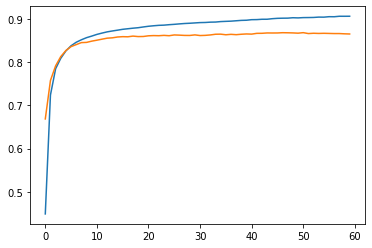

In [41]:
from matplotlib import pyplot as plt

plt.plot(log['train_accuracy'])
plt.plot(log['test_accuracy'])

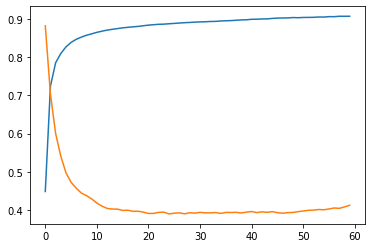

In [42]:
from matplotlib import pyplot as plt
plt.plot(log['train_loss'])
plt.plot(log['test_loss'])

<div dir = "rtl">
    همیانطور که مشاهده میشود تقریبا از آیپاک پنجاه به بعد مقدار خطا شروع به افزایش میکند و اگرچه مقدار دقت روی داده آموزش بسیار خوب است اما کم کم این مقدار روی داده تست کم میشود و این نشان دهنده شروع اورفیتینگ است که اگر فرایند آموزش ادامه یابد داده آموزش را با دقت بالایی مدل میکند ولی روی داده تست خروجی مناسبی نخواهد داشت
به دلیل همین مسئله اورفیت داده ها را برای چند آیپاک آموزش میدهیم تا بفهمیم از کجا دیگر آموزش را ادامه ندهیم
</div>

In [74]:
INPUT_SHAPE = 784
LEARNING_RATE = 0.001
EPOCHS = 10
TRAINLOADER = Dataloader(train_data, train_labels, 10, 32)
TESTLOADER = Dataloader(test_data, test_labels, 10, 32)

network = FeedForwardNN(INPUT_SHAPE)
network.add_layer(10, input_shape=INPUT_SHAPE, activation=LeakyRelu(), weight_initializer='uniform')
network.add_layer(2, activation=LeakyRelu(), weight_initializer='normal')
network.add_layer(10, activation=LeakyRelu(), weight_initializer='uniform')
network.set_training_param(loss=CrossEntropy(), lr=LEARNING_RATE)

log = network.fit(EPOCHS, TRAINLOADER, TESTLOADER)


Epoch 1:
	Train: Average Accuracy: 0.300439247311828	Average Loss: 1.8222108367322543
	Test: Average Accuracy: 0.43620873269435567	Average Loss: 1.4507269502534355
Epoch 2:
	Train: Average Accuracy: 0.513705376344086	Average Loss: 1.152905029070601
	Test: Average Accuracy: 0.5208732694355698	Average Loss: 1.1462829683782123
Epoch 3:
	Train: Average Accuracy: 0.584741935483871	Average Loss: 1.00354514811343
	Test: Average Accuracy: 0.6350173056443024	Average Loss: 0.9554164263507666
Epoch 4:
	Train: Average Accuracy: 0.6651602150537634	Average Loss: 0.8688310537243427
	Test: Average Accuracy: 0.6829273162939297	Average Loss: 0.8325823335594104
Epoch 5:
	Train: Average Accuracy: 0.7100602150537634	Average Loss: 0.7803915960703678
	Test: Average Accuracy: 0.7218051118210863	Average Loss: 0.7657062891543802
Epoch 6:
	Train: Average Accuracy: 0.739660752688172	Average Loss: 0.7191193210462148
	Test: Average Accuracy: 0.7616546858359957	Average Loss: 0.7163094251969178
Epoch 7:
	Train: Avera

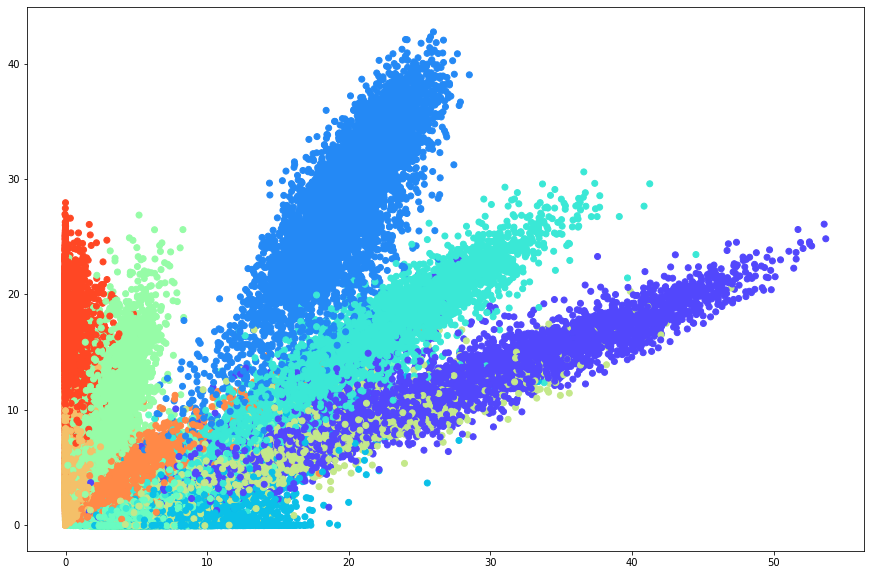

In [130]:
import seaborn as sns
color_for_labels = sns.color_palette("rainbow", 10)

train = network.train
train_y = network.train_y
plt.figure(figsize=(15,10))

j = 0

for batch in train[:-1]:
    x = np.array(batch[:,0])
    y = np.array(batch[:,1])
    color = np.array(train_y[j].argmax(1))
    plt.scatter(x, y, color = [color_for_labels[color[i][0]] for i in range(32)])
    j += 1
    
plt.show()

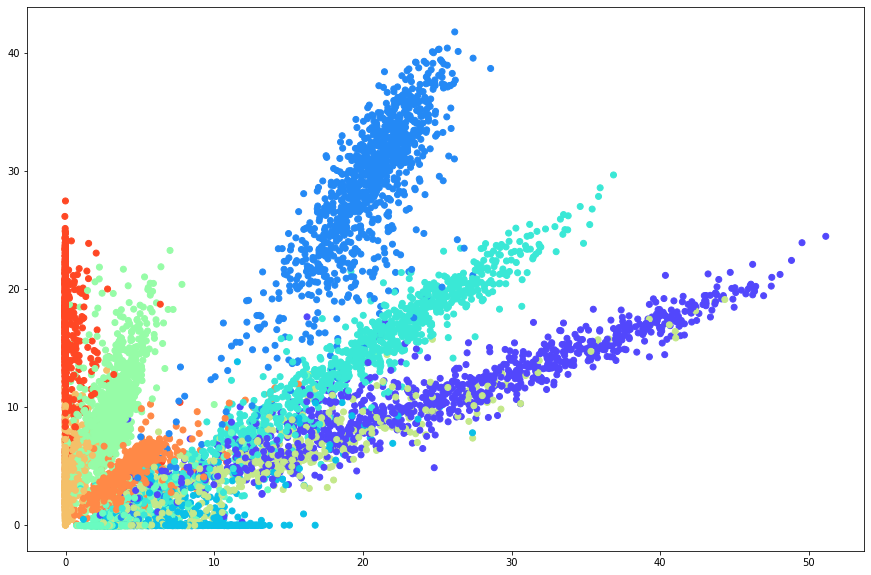

In [133]:
import seaborn as sns
color_for_labels = sns.color_palette("rainbow", 10)

test = network.test
test_y = network.test_y
plt.figure(figsize=(15,10))

j = 0

for batch in test[:-1]:
    x = np.array(batch[:,0])
    y = np.array(batch[:,1])
    color = np.array(test_y[j].argmax(1))
    plt.scatter(x, y, color = [color_for_labels[color[i][0]] for i in range(32)])
    j += 1
    
plt.show()

<div dir = "rtl">
همانطور که در گوشه پایین تصویر مشخص است چندین کلاس در اشتراک زیادی دارند و طبعا تشخیص آنها دشوار است و حتی یک کلاس در درون کلاس دیگر است. اما بعضی از آنها کاملا جدا از بقیه هستند و تشخیص آنها ساده است. به طور کلی داده هایی که جدا از یکدیگر باشند برای شبکه بهتر قابل تشخیص هستند
</div>